<a href="https://colab.research.google.com/github/SUBASH-R-007/Seismic-Hazard-Forecasting-Using-Spatio-Temporal-Graph-Neural-Network/blob/main/STGNN_Seismic_Forecast_JAPAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# --- Install Libraries ---
!pip install numpy pandas torch scikit-learn requests tqdm geopandas shapely joblib matplotlib seaborn

# --- Import Libraries ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    classification_report, confusion_matrix, precision_recall_curve, f1_score
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm.notebook import tqdm
import datetime
import time
import os
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
import joblib

# Suppress specific warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Geometry is empty", category=UserWarning)

# --- !! GPU VERIFICATION !! ---
print("--- Verifying GPU (CUDA) Setup ---")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    if torch.version.cuda: print(f"PyTorch CUDA version: {torch.version.cuda}")
    else: print("PyTorch built without CUDA support.")
    try: _ = torch.tensor([1.0, 2.0]).to(DEVICE); print("SUCCESS: GPU appears connected!")
    except Exception as e: print(f"ERROR: CUDA CHECK FAILED: {e}"); DEVICE = torch.device("cpu"); print("Falling back to CPU.")
else: print("WARNING: CUDA NOT AVAILABLE! Using CPU (SLOW).")
print("----------------------------------------")

# --- Configuration for Japan (High Resolution) ---
print("--- Initializing High-Resolution Configuration for Japan ---")

# Geographic Region (Japan Area)
MIN_LAT, MAX_LAT = 24.0, 46.0
MIN_LON, MAX_LON = 122.0, 146.0
# --- !! RESOLUTION INCREASED !! ---
GRID_RESOLUTION = 0.5  # Increased resolution
# --- END RESOLUTION CHANGE ---

# Data Fetching Parameters
START_DATE = "2000-01-01"
END_DATE = datetime.datetime.now().strftime("%Y-%m-%d")
TARGET_MAGNITUDE = 4.5
MODEL_FILE_PATH = f"best_japan_stgnn_model_m{TARGET_MAGNITUDE}_res{GRID_RESOLUTION}.pth" # Reflect resolution
SCALER_FILE_PATH = f"japan_feature_scaler_m{TARGET_MAGNITUDE}_res{GRID_RESOLUTION}.pkl" # Reflect resolution

# Model Hyperparameters (Keep conservative for memory with higher res)
SEQ_LENGTH = 52
HIDDEN_DIM_1 = 64     # Kept smaller for memory
HIDDEN_DIM_2 = 128    # Kept smaller for memory
DROPOUT_RATE = 0.4

# Training Parameters
EPOCHS = 100
BATCH_SIZE = 8        # Kept small for 8GB VRAM
LEARNING_RATE = 1e-4
PATIENCE = 10
GRADIENT_CLIP_VALUE = 1.0

# Grid Calculation (Will automatically update based on new resolution)
lat_bins = np.arange(MIN_LAT, MAX_LAT + GRID_RESOLUTION, GRID_RESOLUTION)
lon_bins = np.arange(MIN_LON, MAX_LON + GRID_RESOLUTION, GRID_RESOLUTION)
N_LAT_BINS = len(lat_bins) - 1
N_LON_BINS = len(lon_bins) - 1
N_CELLS = N_LAT_BINS * N_LON_BINS # Should be 44 * 48 = 2112
print(f"Japan grid (High Res): {N_LAT_BINS} (lat) x {N_LON_BINS} (lon) = {N_CELLS} cells.")
print(f"Target Magnitude: >= {TARGET_MAGNITUDE}")


--- Verifying GPU (CUDA) Setup ---
Using device: cuda
GPU Name: Tesla T4
PyTorch CUDA version: 12.6
SUCCESS: GPU appears connected!
----------------------------------------
--- Initializing High-Resolution Configuration for Japan ---
Japan grid (High Res): 44 (lat) x 48 (lon) = 2112 cells.
Target Magnitude: >= 4.5


In [2]:
# CELL 2 (Corrected Version - FINAL FINAL FINAL URL Fix)

import requests
import pandas as pd
import datetime
import time
from tqdm.notebook import tqdm # Ensure tqdm.notebook is used

# Define constants from Cell 1 or redefine if needed for standalone cell execution
# Ensure Cell 1 has been run successfully first
if 'MIN_LAT' not in locals() or 'MAX_LAT' not in locals() or \
   'MIN_LON' not in locals() or 'MAX_LON' not in locals():
      # Define defaults if running standalone (not recommended)
      print("Warning: Running Cell 2 standalone, using default region bounds.")
      MIN_LAT, MAX_LAT = 24.0, 46.0 # Japan defaults
      MIN_LON, MAX_LON = 122.0, 146.0

def fetch_usgs_data_in_chunks(start_date_str, end_date_str, min_mag=1.0):
    """Fetches regional data in monthly chunks with retries."""
    print(f"\n--- Fetching Data from USGS for Region ({MIN_LAT}-{MAX_LAT}°N, {MIN_LON}-{MAX_LON}°E) ---")
    try:
        start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
        end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")
    except ValueError:
        print("Error: Invalid date format. Please use YYYY-MM-DD.")
        return pd.DataFrame()

    all_events_df = pd.DataFrame()

    # --- THIS IS THE VERIFIED, PLAIN STRING URL ---
    URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    # --- END OF VERIFIED URL ---

    current_start = start_date
    total_months = max(1, (end_date.year - start_date.year) * 12 + end_date.month - start_date.month + 1)
    pbar_fetch = tqdm(total=total_months, desc="Fetching Data Chunks")

    while current_start < end_date:
        # Calculate end time for the query (exclusive)
        next_month_start = (current_start.replace(day=1) + pd.DateOffset(months=1)).replace(tzinfo=None)
        current_end_query = min(next_month_start, end_date)

        pbar_fetch.set_description(f"Fetching {current_start.strftime('%Y-%m-%d')} to {current_end_query.strftime('%Y-%m-%d')}")

        params = {
            'format': 'geojson',
            'starttime': current_start.strftime('%Y-%m-%dT%H:%M:%S'),
            'endtime': current_end_query.strftime('%Y-%m-%dT%H:%M:%S'),
            'minlatitude': MIN_LAT, 'maxlatitude': MAX_LAT,
            'minlongitude': MIN_LON, 'maxlongitude': MAX_LON,
            'minmagnitude': min_mag, 'orderby': 'time', 'limit': 20000
        }
        retries = 3
        success = False
        for attempt in range(retries):
            try:
                # --- Use the corrected URL variable ---
                response = requests.get(URL, params=params, timeout=300)
                # --- End URL usage ---
                response.raise_for_status()
                data = response.json()
                if 'features' in data and isinstance(data['features'], list):
                    features = []
                    for e in data['features']:
                         props=e.get('properties',{}); geom=e.get('geometry',{}); coords=geom.get('coordinates'); mag=props.get('mag'); event_time=props.get('time')
                         if geom and coords and len(coords)>=2 and mag is not None and event_time is not None:
                              try: features.append({'time': pd.to_datetime(event_time, unit='ms', utc=True), 'latitude': coords[1], 'longitude': coords[0], 'magnitude': mag})
                              except (TypeError, ValueError) as dt_err: print(f"    Warn: Skip event time parse error: {dt_err}")
                    if features: all_events_df = pd.concat([all_events_df, pd.DataFrame(features)], ignore_index=True)
                else: print(f"Warn: No 'features' list.")
                time.sleep(0.5); success = True; break
            except requests.exceptions.HTTPError as http_err: print(f"    Warn: HTTP Err (Try {attempt+1}): {http_err}. Code: {response.status_code if 'response' in locals() else 'N/A'}"); time.sleep(2*(attempt+1))
            except requests.exceptions.RequestException as e: print(f"    Warn: Conn/Timeout Err (Try {attempt+1}): {e}."); time.sleep(2*(attempt+1))
            except Exception as e: print(f"   Warn: Other fetch err (Try {attempt+1}): {e}"); time.sleep(2*(attempt+1))
        if not success: print(f"Skip chunk {current_start.strftime('%Y-%m-%d')} fail.")

        current_start = current_end_query
        pbar_fetch.update(1)
    pbar_fetch.close()

    if not all_events_df.empty:
         all_events_df.drop_duplicates(subset=['time', 'latitude', 'longitude', 'magnitude'], inplace=True)
         print(f"Fetched {len(all_events_df)} unique events from {all_events_df['time'].min()} to {all_events_df['time'].max()}.")
    else: print("Warning: No events fetched.")
    return all_events_df

In [3]:
# Cell 3 code (preprocess_data, create_regional_adjacency_matrix) is identical to the previous
# final Japan notebook version. It uses the grid parameters defined in Cell 1.
# It includes robust resampling, scaler fitting/loading, and the regional adjacency matrix logic.

def preprocess_data(df, scaler=None, fit_scaler=False):
    """ Processes regional data, applies scaling. Robust resampling. """
    print("\n--- Preprocessing Data (Japan Region - High Res) ---") # Updated print statement
    if df is None or df.empty: print("Input DF empty."); return None, None, None, None
    required_cols = ['time', 'latitude', 'longitude', 'magnitude']
    if not all(col in df.columns for col in required_cols): print(f"Error: Missing cols: {required_cols}"); return None, None, None, None
    if not pd.api.types.is_datetime64_any_dtype(df['time']): print("Error: 'time' not datetime."); return None, None, None, None
    if df['time'].dt.tz is None: df['time'] = df['time'].dt.tz_localize('UTC')
    df.dropna(subset=required_cols, inplace=True)
    if df.empty: print("DF empty after dropna."); return None, None, None, None

    # 1. Feature Engineering
    df['energy_release'] = 10**(1.5 * df['magnitude'] + 4.8)

    # 2. Assign to grid cells (uses global bins defined in Cell 1)
    df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True, right=False)
    df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True, right=False)
    df['cell_id'] = df['lat_bin'] * N_LON_BINS + df['lon_bin']
    df.dropna(subset=['lat_bin', 'lon_bin', 'cell_id'], inplace=True)
    df = df[(df['cell_id'] >= 0) & (df['cell_id'] < N_CELLS)] # Use N_CELLS (now 2112)
    if df.empty:
        print("Warn: No events in grid bounds.")
        empty_index = pd.DatetimeIndex([])
        feature_cols = ['count_m1+', 'count_m2+', 'count_m3+', 'count_m4+', 'max_mag', 'mean_mag', 'energy_release']
        empty_multi_index = pd.MultiIndex.from_product([feature_cols, range(N_CELLS)], names=['feature', 'cell_id'])
        empty_features = pd.DataFrame(index=empty_index, columns=empty_multi_index).astype(float)
        empty_labels = pd.DataFrame(index=empty_index, columns=range(N_CELLS)).astype(int)
        return empty_features, empty_labels, empty_index, scaler
    df['cell_id'] = df['cell_id'].astype(int)

    # 3. Resample weekly & create features
    df_copy = df.copy(); df_copy.set_index('time', inplace=True)
    aggregations = {'magnitude': ['max', 'mean'], 'energy_release': 'sum'}

    def safe_resample(df_group, size_col=None, agg_dict=None, name=None):
        try:
            if df_group.empty: raise ValueError("Input empty")
            grouped = df_group.groupby('cell_id')
            if size_col: resampled = grouped.resample('W-Sun').size().reset_index(name=name)
            elif agg_dict:
                resampled = grouped.resample('W-Sun').agg(agg_dict)
                if isinstance(resampled.columns, pd.MultiIndex): resampled.columns = ['_'.join(col).strip() for col in resampled.columns.values]
                resampled = resampled.reset_index()
            else: return pd.DataFrame()
            return resampled
        except ValueError: pass
        except Exception as e: print(f"Warn resampling '{name or 'agg'}': {e}.")
        cols = ['time', 'cell_id'];
        if size_col: cols.append(name)
        elif agg_dict:
             agg_names = ['_'.join(col).strip() for col in pd.MultiIndex.from_product([agg_dict.keys(), agg_dict.get('magnitude',[])])] + ['energy_release_sum']
             cols.extend(agg_names)
        return pd.DataFrame(columns=cols)

    weekly_m1 = safe_resample(df_copy[df_copy['magnitude'] >= 1.0], size_col=True, name='count_m1+')
    weekly_m2 = safe_resample(df_copy[df_copy['magnitude'] >= 2.0], size_col=True, name='count_m2+')
    weekly_m3 = safe_resample(df_copy[df_copy['magnitude'] >= 3.0], size_col=True, name='count_m3+')
    weekly_m4 = safe_resample(df_copy[df_copy['magnitude'] >= 4.0], size_col=True, name='count_m4+')
    weekly_agg = safe_resample(df_copy, agg_dict=aggregations, name='agg')
    rename_dict = {'magnitude_max': 'max_mag', 'magnitude_mean': 'mean_mag', 'energy_release_sum': 'energy_release'}
    weekly_agg.rename(columns={k: v for k, v in rename_dict.items() if k in weekly_agg.columns}, inplace=True)

    # 4. Create grid template
    min_time, max_time = df_copy.index.min(), df_copy.index.max()
    if pd.isna(min_time) or pd.isna(max_time): print("Error: Invalid time range."); return None, None, None, scaler
    start_week = min_time.normalize() - pd.Timedelta(days=(min_time.weekday() + 1) % 7)
    all_weeks = pd.date_range(start=start_week, end=max_time, freq='W-Sun')
    if all_weeks.empty:
         print("Warn: Data < 1 week.");
         if not df_copy.empty: sunday = min_time + pd.Timedelta(days=6 - min_time.weekday()); all_weeks = pd.DatetimeIndex([sunday]).tz_localize('UTC')
         else: return None, None, None, scaler
    grid_template = pd.MultiIndex.from_product([all_weeks, range(N_CELLS)], names=['time', 'cell_id']) # Use N_CELLS (2112)
    final_df = pd.DataFrame(index=grid_template).reset_index()

    # 5. Merge features
    features_list = [weekly_m1, weekly_m2, weekly_m3, weekly_m4, weekly_agg]
    merge_cols = ['time', 'cell_id']
    for features_df in features_list:
        if features_df is not None and not features_df.empty:
            if all(col in features_df.columns for col in merge_cols):
                 if features_df['time'].dt.tz is None: features_df['time'] = features_df['time'].dt.tz_localize('UTC')
                 try: final_df = pd.merge(final_df, features_df, on=merge_cols, how='left')
                 except Exception as e: print(f"Error merging features: {e}.")
            else: print(f"Skip merge: missing cols.")
    final_df.fillna(0, inplace=True)

    # 6. Generate labels
    labels_df = safe_resample(df_copy[df_copy['magnitude'] >= TARGET_MAGNITUDE], size_col=True, name='event')
    if labels_df is not None and not labels_df.empty and 'event' in labels_df.columns:
        labels_df['event'] = (labels_df['event'] > 0).astype(int)
        if all(col in labels_df.columns for col in merge_cols):
             if labels_df['time'].dt.tz is None: labels_df['time'] = labels_df['time'].dt.tz_localize('UTC')
             try: final_df = pd.merge(final_df, labels_df, on=merge_cols, how='left')
             except Exception as e: print(f"Error merging labels: {e}.")
        else: final_df['event'] = 0
    else: final_df['event'] = 0
    final_df.fillna({'event': 0}, inplace=True)

    # 7. Pivot
    feature_cols = ['count_m1+', 'count_m2+', 'count_m3+', 'count_m4+', 'max_mag', 'mean_mag', 'energy_release']
    for col in feature_cols:
         if col not in final_df.columns: final_df[col] = 0.0

    print("Pivoting data...")
    try:
        final_df.drop_duplicates(subset=['time', 'cell_id'], keep='last', inplace=True)
        features_pivot = final_df.pivot(index='time', columns='cell_id', values=feature_cols)
        labels_pivot = final_df.pivot(index='time', columns='cell_id', values='event')
    except Exception as e: print(f"Error pivoting: {e}."); return None, None, None, scaler

    # Reindex & type conversion
    feature_multi_index = pd.MultiIndex.from_product([feature_cols, range(N_CELLS)], names=['feature', 'cell_id']) # Use N_CELLS (2112)
    features_pivot = features_pivot.reindex(columns=feature_multi_index, fill_value=0.0).astype(float)
    labels_pivot = labels_pivot.reindex(columns=range(N_CELLS), fill_value=0).astype(int) # Use N_CELLS (2112)

    # --- SCALING ---
    print("Applying Feature Scaling...")
    n_samples = features_pivot.shape[0]
    if n_samples == 0: print("Warn: No samples post-pivot."); return features_pivot, labels_pivot, labels_pivot.index, scaler

    try: # Robust reshaping
        values_temp = features_pivot.values.reshape(n_samples, len(feature_cols), N_CELLS) # Use N_CELLS (2112)
        values_transposed = values_temp.transpose(0, 2, 1)
        features_reshaped = values_transposed.reshape(n_samples * N_CELLS, len(feature_cols)) # Use N_CELLS (2112)
    except Exception as e: print(f"Error reshaping for scaler: {e}"); return features_pivot, labels_pivot, labels_pivot.index, scaler

    current_scaler = scaler; scaler_ready = False
    if fit_scaler:
        print("Fitting new scaler...")
        current_scaler = StandardScaler()
        if features_reshaped.shape[0] > 0:
            try:
                current_scaler.fit(features_reshaped)
                joblib.dump(current_scaler, SCALER_FILE_PATH) # Use Japan path
                print(f"Scaler saved to {SCALER_FILE_PATH}"); scaler_ready = True
            except Exception as e: print(f"Error fitting/saving scaler: {e}")
        else: print("Warn: No data to fit scaler.")
    elif current_scaler is None:
         if os.path.exists(SCALER_FILE_PATH):
             try: current_scaler = joblib.load(SCALER_FILE_PATH); print(f"Loaded scaler: {SCALER_FILE_PATH}"); scaler_ready = True
             except Exception as e: print(f"Error loading scaler: {e}.")
         else: print("Warn: Scaler file not found.")
    else: scaler_ready = hasattr(current_scaler, 'mean_')

    scaled_features_pivot = features_pivot # Default unscaled
    if scaler_ready and hasattr(current_scaler, 'mean_') and current_scaler.mean_ is not None:
        try:
            features_scaled_reshaped = current_scaler.transform(features_reshaped)
            features_scaled_temp = features_scaled_reshaped.reshape(n_samples, N_CELLS, len(feature_cols)) # Use N_CELLS (2112)
            features_scaled_transposed = features_scaled_temp.transpose(0, 2, 1)
            features_scaled = features_scaled_transposed.reshape(n_samples, len(feature_cols) * N_CELLS) # Use N_CELLS (2112)
            scaled_features_pivot = pd.DataFrame(features_scaled, index=features_pivot.index, columns=features_pivot.columns)
            print("Scaling applied.")
        except Exception as e: print(f"Error applying scaling: {e}.")
    else: print("Warn: Scaler not ready/fitted. Returning unscaled.")

    print("Preprocessing complete.")
    return scaled_features_pivot, labels_pivot, labels_pivot.index, current_scaler

# --- Regional Adjacency Matrix (No Wrap-Around) ---
def create_regional_adjacency_matrix():
    """ Creates normalized adjacency matrix for the Japan grid (no longitude wrap). """
    print("\nCreating Regional Adjacency Matrix (Japan - High Res)...") # Updated print
    # Uses global N_CELLS, N_LAT_BINS, N_LON_BINS (now 2112, 44, 48)
    adj = np.zeros((N_CELLS, N_CELLS), dtype=np.float32)
    for i in range(N_LAT_BINS):
        for j in range(N_LON_BINS):
            node_idx = i * N_LON_BINS + j
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    # Check BOTH bounds (NO WRAP)
                    if 0 <= ni < N_LAT_BINS and 0 <= nj < N_LON_BINS:
                        neighbor_idx = ni * N_LON_BINS + nj
                        adj[node_idx, neighbor_idx] = 1.0
    # Normalize
    D = np.sum(adj, axis=1); D[D <= 0] = 1.0
    D_inv_sqrt = 1.0 / np.sqrt(D); D_inv_sqrt_matrix = np.diag(D_inv_sqrt)
    adj_normalized = D_inv_sqrt_matrix @ adj @ D_inv_sqrt_matrix
    print("Regional Adjacency Matrix created.")
    return torch.tensor(adj_normalized, dtype=torch.float32).to(DEVICE)


In [4]:
# Cell 4 code (SeismicDataset, STGNN, EarlyStopping) is identical to the previous
# final global notebook version. It uses the model and grid parameters
# defined in Cell 1 (now with N_CELLS=2112 and potentially adjusted HIDDEN_DIMs).

class SeismicDataset(Dataset):
    """ PyTorch Dataset for lazy loading. Handles potential errors. """
    def __init__(self, features_pivot_df, labels_pivot_df):
        if features_pivot_df is None or labels_pivot_df is None or features_pivot_df.empty or labels_pivot_df.empty:
             raise ValueError("Input DataFrames cannot be None or empty")
        # Align labels only after checking features length
        if len(features_pivot_df) < SEQ_LENGTH:
             raise ValueError(f"Features length ({len(features_pivot_df)}) < SEQ_LENGTH ({SEQ_LENGTH}).")

        self.features_pivot = features_pivot_df
        # Align labels: ensure labels start from the end of the first possible sequence
        self.labels_pivot = labels_pivot_df.iloc[SEQ_LENGTH:]
        self._len = max(0, len(self.features_pivot) - SEQ_LENGTH)

        # Final length check
        if self._len != len(self.labels_pivot):
            print(f"Warn: Length mismatch post-align. Dataset len: {self._len}, Aligned Labels: {len(self.labels_pivot)}. Adjusting.")
            self._len = min(self._len, len(self.labels_pivot)) # Adjust to min consistent

        # Robustly get n_features
        if isinstance(self.features_pivot.columns, pd.MultiIndex):
            try: self.n_features = len(self.features_pivot.columns.levels[0])
            except IndexError: self.n_features = self.features_pivot.shape[1] // N_CELLS
        else:
             self.n_features = self.features_pivot.shape[1] // N_CELLS
             if self.features_pivot.shape[1] % N_CELLS != 0: raise ValueError(f"Cols ({self.features_pivot.shape[1]}) not divisible by N_CELLS ({N_CELLS}).")
        if self.n_features <= 0: raise ValueError(f"Inferred n_features ({self.n_features}) invalid.")

        self.features_values = self.features_pivot.values
        self.labels_values = self.labels_pivot.values # Use aligned labels values

        print(f"Dataset init. Samples: {self._len}, Feats/cell: {self.n_features}")
        if self._len == 0: print("Warn: Dataset length is 0.")


    def __len__(self): return self._len

    def __getitem__(self, idx):
        if not (0 <= idx < self._len): raise IndexError(f"Index {idx} out of bounds for len {self._len}")
        feature_start_idx, feature_end_idx = idx, idx + SEQ_LENGTH
        label_idx = idx # Index for the *aligned* labels_values

        X_data = self.features_values[feature_start_idx : feature_end_idx]
        y_data = self.labels_values[label_idx]

        try:
             expected_elements = SEQ_LENGTH * N_CELLS * self.n_features # N_CELLS for Japan
             if X_data.size != expected_elements: raise ValueError(f"Data slice size mismatch. Expected {expected_elements}, got {X_data.size}")
             X_data_cont = np.ascontiguousarray(X_data)
             X_tensor = torch.tensor(X_data_cont, dtype=torch.float32).reshape(SEQ_LENGTH, N_CELLS, self.n_features) # N_CELLS for Japan
        except Exception as e: print(f"Error reshape features idx {idx}: {e}"); raise e
        y_tensor = torch.tensor(y_data, dtype=torch.float32)
        return X_tensor, y_tensor


# --- MEMORY-EFFICIENT ARCHITECTURE ---
class STGNN(nn.Module):
    """ Temporal-First STGNN Architecture with Initialization. """
    def __init__(self, n_nodes, n_features, adj_matrix):
        super(STGNN, self).__init__()
        self.adj_matrix = adj_matrix.to(DEVICE) if adj_matrix is not None else None
        self.n_nodes = n_nodes # Should be Japan's N_CELLS
        self.n_features = n_features

        # Use HIDDEN_DIMs from Cell 1
        self.temporal_block = nn.GRU(input_size=n_features, hidden_size=HIDDEN_DIM_1, num_layers=2, batch_first=True, dropout=DROPOUT_RATE)
        for name, param in self.temporal_block.named_parameters(): # Init GRU
            if 'weight_ih' in name: torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name: torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name: param.data.fill_(0)

        self.spatial_block = nn.Linear(HIDDEN_DIM_1, HIDDEN_DIM_2)
        torch.nn.init.xavier_uniform_(self.spatial_block.weight) # Init Linear
        self.layer_norm = nn.LayerNorm(HIDDEN_DIM_2)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fc = nn.Linear(HIDDEN_DIM_2, 1)
        torch.nn.init.xavier_uniform_(self.fc.weight); self.fc.bias.data.fill_(0) # Init Linear

    def forward(self, x):
        x = x.to(DEVICE)
        batch_size, seq_len, nodes_in, n_feats_in = x.shape
        if nodes_in != self.n_nodes: raise ValueError(f"Node mismatch: {nodes_in} vs {self.n_nodes}")
        if n_feats_in != self.n_features: raise ValueError(f"Feature mismatch: {n_feats_in} vs {self.n_features}")

        x_temporal_in = x.permute(0, 2, 1, 3).reshape(batch_size * self.n_nodes, seq_len, self.n_features)
        _, hidden = self.temporal_block(x_temporal_in)
        h_temporal_out = hidden[-1, :, :].reshape(batch_size, self.n_nodes, HIDDEN_DIM_1)

        if self.adj_matrix is not None:
             if h_temporal_out.device != self.adj_matrix.device: h_temporal_out = h_temporal_out.to(self.adj_matrix.device)
             h_spatial_in = torch.matmul(self.adj_matrix, h_temporal_out)
        else: h_spatial_in = h_temporal_out

        h_spatial_out = torch.relu(self.spatial_block(h_spatial_in))
        h_spatial_out = self.dropout(self.layer_norm(h_spatial_out))
        output = self.fc(h_spatial_out).squeeze(-1)
        return torch.sigmoid(output)

class EarlyStopping:
    """ Stops training when validation loss doesn't improve. Handles NaN loss. """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience, self.verbose, self.delta, self.path = patience, verbose, delta, path
        self.counter, self.best_score, self.early_stop = 0, None, False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        if np.isnan(val_loss): print("Warn: Val loss NaN. Stop check skipped."); return
        score = -val_loss
        if self.best_score is None: self.best_score = score; self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1; print(f'EarlyStop counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience: print("--- Early stopping triggered ---"); self.early_stop = True
        else: self.best_score = score; self.save_checkpoint(val_loss, model); self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Val loss decreased ({self.val_loss_min:.6f} -> {val_loss:.6f}). Saving model to {self.path} ...')
        try: torch.save(model.state_dict(), self.path)
        except Exception as e: print(f"Error saving checkpoint: {e}")
        self.val_loss_min = val_loss # Update min loss


In [5]:
# Cell 5 code (train_model function) is identical to the previous final global
# notebook version. It includes robust batch processing, NaN checks, gradient clipping,
# history tracking, and plotting.

def train_model(train_loader, val_loader, model, optimizer, criterion, scheduler, early_stopper):
    print("\n--- Starting Model Training ---")
    if val_loader is None: print("Warn: No validation loader.")
    history = {'train_loss': [], 'val_loss': [], 'val_pr_auc': []}

    for epoch in range(EPOCHS):
        model.train(); total_train_loss=0; processed_batches_train=0
        pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
        for i, batch in enumerate(pbar_train):
            try: features, labels = batch; features, labels = features.to(DEVICE), labels.to(DEVICE)
            except Exception as e: print(f"\nError load train batch {i}: {e}. Skip."); continue
            optimizer.zero_grad()
            try:
                outputs = model(features); loss = criterion(outputs, labels)
                if torch.isnan(loss) or torch.isinf(loss): print(f"\nWarn: Invalid loss train batch {i}. Skip backprop."); continue
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_VALUE)
                optimizer.step(); total_train_loss += loss.item(); processed_batches_train += 1
            except Exception as e: print(f"\nError train step {i}: {e}")
            if processed_batches_train > 0: pbar_train.set_postfix(train_loss=f"{(total_train_loss / processed_batches_train):.4f}")

        if processed_batches_train == 0: print(f"Epoch {epoch+1}: No train batches processed. Stop."); break
        avg_train_loss = total_train_loss / processed_batches_train
        history['train_loss'].append(avg_train_loss)

        avg_val_loss = float('inf'); val_pr_auc = 0.0
        if val_loader:
            model.eval(); total_val_loss = 0; all_labels_val, all_outputs_val = [], []; processed_batches_val = 0
            with torch.no_grad():
                 pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
                 for i, batch in enumerate(pbar_val):
                    try: features, labels = batch; features, labels = features.to(DEVICE), labels.to(DEVICE)
                    except Exception as e: print(f"Error load val batch {i}: {e}. Skip."); continue
                    try:
                        outputs = model(features); loss = criterion(outputs, labels)
                        if torch.isnan(loss) or torch.isinf(loss): print(f"\nWarn: Invalid loss val batch {i}. Skip."); continue
                        total_val_loss += loss.item(); all_labels_val.append(labels.cpu().numpy().flatten()); all_outputs_val.append(outputs.cpu().numpy().flatten()); processed_batches_val += 1
                    except Exception as e: print(f"Error val step {i}: {e}")
                    if processed_batches_val > 0: pbar_val.set_postfix(val_loss=f"{(total_val_loss / processed_batches_val):.4f}")

            if processed_batches_val > 0:
                 avg_val_loss = total_val_loss / processed_batches_val; history['val_loss'].append(avg_val_loss)
                 if all_labels_val:
                     lbl_flat, out_flat = np.concatenate(all_labels_val), np.concatenate(all_outputs_val)
                     valid_idx = ~np.isnan(lbl_flat) & ~np.isnan(out_flat); lbl_clean, out_clean = lbl_flat[valid_idx], out_flat[valid_idx]
                     if len(np.unique(lbl_clean)) > 1 and len(lbl_clean) > 0:
                        try: val_pr_auc = average_precision_score(lbl_clean, out_clean)
                        except ValueError as e: print(f"Could not calc PR-AUC: {e}")
            else: print("Warn: No val batches processed."); history['val_loss'].append(float('inf'))
            history['val_pr_auc'].append(val_pr_auc)
            print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val PR-AUC: {val_pr_auc:.4f}")
            if np.isfinite(avg_val_loss): scheduler.step(avg_val_loss); early_stopper(avg_val_loss, model);
            else: print("Skip scheduler/early stop check.")
            if early_stopper.early_stop: break
        else: # No validation
             history['val_loss'].append(None); history['val_pr_auc'].append(None)
             print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | (No Val)")
             try: torch.save(model.state_dict(), MODEL_FILE_PATH) # Save each epoch
             except Exception as e: print(f"Error saving model: {e}")

    print("--- Training Finished ---"); return history


In [17]:
# CELL 6 (Corrected Version - Accepts Grid Arguments)

import joblib # Ensure joblib is imported here too
import geopandas as gpd # Ensure geopandas is imported
from shapely.geometry import Polygon # Ensure Polygon is imported
import matplotlib.pyplot as plt # Ensure pyplot is imported
import numpy as np # Ensure numpy is imported
import datetime # Ensure datetime is imported
import pandas as pd # Ensure pandas is imported
import torch # Ensure torch is imported
from tqdm.notebook import tqdm # Ensure tqdm is imported
import os # Ensure os is imported

# Need access to fetch_usgs_data_in_chunks (Cell 2) and preprocess_data (Cell 3)
# Ensure Cells 2 and 3 have been run successfully
if 'fetch_usgs_data_in_chunks' not in locals() or 'preprocess_data' not in locals():
     raise NameError("Required functions fetch_usgs_data_in_chunks or preprocess_data not defined. Run Cells 2 & 3.")
# Need access to globals for predict_latest_hazard
if 'SEQ_LENGTH' not in locals() or 'DEVICE' not in locals() or \
   'N_CELLS' not in locals() or 'SCALER_FILE_PATH' not in locals():
       raise NameError("One or more required global variables are not defined. Please run Cell 1 first.")


def predict_latest_hazard(model, scaler):
    """Fetches latest data for Japan region, scales it, predicts hazard."""
    # (Function body remains identical to the previous 'perfect' version)
    print("\n--- Generating Forecast for Next Week (Japan Region - High Res) ---")
    utc_now = datetime.datetime.now(datetime.timezone.utc)
    start_pred_date = (utc_now - datetime.timedelta(weeks=SEQ_LENGTH + 10)).strftime("%Y-%m-%d")
    end_pred_date = utc_now.strftime("%Y-%m-%d")
    df_pred = fetch_usgs_data_in_chunks(start_pred_date, end_pred_date, min_mag=1.0)
    if df_pred is None or df_pred.empty: print("Failed fetch predict data."); return None
    if scaler is None or not hasattr(scaler, 'mean_'):
         print("Error: Scaler invalid.");
         if os.path.exists(SCALER_FILE_PATH):
             try: scaler = joblib.load(SCALER_FILE_PATH); print(f"Loaded scaler: {SCALER_FILE_PATH}.");
             except Exception as e: print(f"Error load scaler: {e}. Cannot predict."); return None
             if not hasattr(scaler, 'mean_'): print("Loaded object not scaler."); return None
         else: print(f"Scaler file {SCALER_FILE_PATH} missing."); return None
    features_pivot, _, _, _ = preprocess_data(df_pred, scaler=scaler, fit_scaler=False)
    if features_pivot is None or features_pivot.empty: print("Preproc failed."); return None
    if len(features_pivot) < SEQ_LENGTH: print(f"Not enough data ({len(features_pivot)}w) for seq ({SEQ_LENGTH})."); return None
    latest_sequence_data = features_pivot.iloc[-SEQ_LENGTH:].values
    if hasattr(model, 'n_features'): n_features = model.n_features
    elif isinstance(features_pivot.columns, pd.MultiIndex) and features_pivot.shape[1] % N_CELLS == 0: n_features = len(features_pivot.columns.levels[0])
    elif features_pivot.shape[1] % N_CELLS == 0: n_features = features_pivot.shape[1] // N_CELLS
    else: print("Error: Cannot determine n_features."); return None
    if n_features <= 0: print(f"Error: Invalid n_features ({n_features})."); return None
    try: latest_sequence = torch.tensor(latest_sequence_data, dtype=torch.float32).reshape(1, SEQ_LENGTH, N_CELLS, n_features).to(DEVICE)
    except Exception as e: print(f"Error reshape sequence: {e}"); return None
    model.eval(); hazard_probs = None
    with torch.no_grad():
        try:
            hazard_probs = model(latest_sequence).cpu().numpy().flatten()
            if np.isnan(hazard_probs).any(): print("Warn: NaN in output. Replacing with 0."); hazard_probs = np.nan_to_num(hazard_probs, nan=0.0)
        except Exception as e: print(f"Error during prediction: {e}"); return None
    if hazard_probs is not None: print(f"Prediction OK. Shape: {hazard_probs.shape}. Min: {hazard_probs.min():.2e}, Max: {hazard_probs.max():.2e}")
    return hazard_probs


# --- !! MODIFIED FUNCTION SIGNATURE !! ---
def visualize_regional_hazard_map(probabilities, lat_bins_vis, lon_bins_vis, N_LAT_BINS_vis, N_LON_BINS_vis, N_CELLS_vis, MIN_LAT_vis, MAX_LAT_vis, MIN_LON_vis, MAX_LON_vis, TARGET_MAGNITUDE_vis):
    """Creates GeoPandas map zoomed to the specified region, using passed grid parameters."""
    print("\n--- Visualizing Hazard Map (Japan Region - High Res) ---")
    # --- Use passed arguments instead of globals ---
    if probabilities is None: print("Cannot generate map: No probabilities."); return
    if len(probabilities) != N_CELLS_vis: print(f"Error: Probs length ({len(probabilities)}) != N_CELLS ({N_CELLS_vis})."); return
    if np.isnan(probabilities).any(): print("Warn: NaN values replaced with 0."); probabilities = np.nan_to_num(probabilities, nan=0.0)

    # Create polygons using passed bins
    polygons = []
    # Check passed bin arrays
    if lat_bins_vis is None or lon_bins_vis is None or len(lat_bins_vis) != N_LAT_BINS_vis + 1 or len(lon_bins_vis) != N_LON_BINS_vis + 1:
         print("Error creating polygons: Passed lat_bins_vis or lon_bins_vis incorrect.")
         return
    for i in range(N_LAT_BINS_vis): # Use passed N_LAT_BINS_vis
        lat1, lat2 = lat_bins_vis[i], lat_bins_vis[i+1]
        for j in range(N_LON_BINS_vis): # Use passed N_LON_BINS_vis
            lon1, lon2 = lon_bins_vis[j], lon_bins_vis[j+1]
            polygons.append(Polygon([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))
    if len(polygons) != N_CELLS_vis: print(f"Error: Polygon mismatch ({len(polygons)} vs {N_CELLS_vis})."); return
    # --- End using passed arguments ---

    grid_gdf = gpd.GeoDataFrame({'geometry': polygons, 'hazard_prob': probabilities}, crs="EPSG:4326")

    # --- Use plain string URL (Verified) ---
    world_map_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    # --- End URL fix ---
    print(f"Loading world map from: {world_map_url}")
    world = None
    try: world = gpd.read_file(world_map_url)
    except Exception as e: print(f"!!! Warning: Error loading world map: {e}")

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    if world is not None: world.plot(ax=ax, color='#E0E0E0', edgecolor='#AAAAAA', linewidth=0.5, alpha=0.8)
    else: ax.set_facecolor('#E0E0E0')

    min_prob, max_prob = np.min(probabilities), np.max(probabilities)
    print(f"Plotting probabilities ranging from {min_prob:.3e} to {max_prob:.3e}")
    vmin, vmax = min_prob, max_prob
    if min_prob == max_prob: vmax = min_prob + 1e-9 if min_prob == 0 else min_prob * 1.1

    plot = grid_gdf.plot(column='hazard_prob', ax=ax, legend=True, cmap='Reds', alpha=0.75, vmin=vmin, vmax=vmax,
                  # --- Use passed TARGET_MAGNITUDE_vis ---
                  legend_kwds={'label': f"Prob M{TARGET_MAGNITUDE_vis}+ Next Week", 'orientation': "horizontal", 'pad': 0.05, 'shrink': 0.5, 'format': "%.2e"})

    # --- Zoom using passed MIN/MAX LON/LAT ---
    ax.set_xlim(MIN_LON_vis, MAX_LON_vis); ax.set_ylim(MIN_LAT_vis, MAX_LAT_vis)
    # --- End zoom ---
    ax.set_title("Seismic Hazard Forecast (Japan Region - 0.5°)", fontsize=18)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel(None); ax.set_ylabel(None)
    plt.tight_layout(); plt.show()

In [7]:
# CELL 7 (Corrected Version - Removed problematic .loc verification)

# --- Main Data Preparation ---

# 1. Fetch Japan Data
# Check if data exists in memory, otherwise fetch
if 'raw_df_japan' not in locals() or raw_df_japan.empty: # Use a specific variable name
     raw_df_japan = fetch_usgs_data_in_chunks(START_DATE, END_DATE, min_mag=1.0) # Uses Japan bounds from Cell 1

if raw_df_japan is None or raw_df_japan.empty:
    raise SystemExit("Fatal: No data fetched for Japan region.")
else:
    # 2. Preprocess FULL Japan dataset *without fitting scaler* initially
    print("\n--- Preprocessing Full Japan Dataset (Initial Pass) ---")
    features_pivot_full, labels_pivot_full, all_timestamps, _ = preprocess_data(
        raw_df_japan.copy(), scaler=None, fit_scaler=False
    )

    if features_pivot_full is None or features_pivot_full.empty or labels_pivot_full.empty:
         raise SystemExit("Fatal: Initial preprocessing failed or resulted in empty DataFrame(s).")
    elif len(features_pivot_full) <= SEQ_LENGTH:
         raise SystemExit(f"Fatal: Not enough data ({len(features_pivot_full)} weeks) for sequence length ({SEQ_LENGTH}).")
    else:
        print("\nFull dataset structure OK.")

        # --- !! STRATIFIED TRAIN/TEST SPLIT !! ---
        # 3. Create stratification key and split indices
        print("\nPerforming Stratified Train/Test Split...")
        stratify_labels_full = labels_pivot_full.iloc[SEQ_LENGTH:].any(axis=1).astype(int)
        num_samples = len(features_pivot_full) - SEQ_LENGTH
        if len(stratify_labels_full) != num_samples: # Alignment check
             print(f"Warning: Aligning stratification labels ({len(stratify_labels_full)}) with samples ({num_samples}).")
             stratify_labels_full = stratify_labels_full.iloc[:num_samples]
             if len(stratify_labels_full) != num_samples: raise SystemExit(f"Fatal: Cannot align labels ({len(stratify_labels_full)}) with samples ({num_samples}).")
        indices = np.arange(num_samples)
        min_pos_samples_needed = 2; total_pos_samples = stratify_labels_full.sum()
        print(f"Total positive samples available for splitting: {total_pos_samples}")
        if total_pos_samples < min_pos_samples_needed * 2:
            print(f"Warning: Few positive samples ({total_pos_samples}). Using random split."); train_val_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)
        else:
            try:
                 test_size_actual = 0.2
                 train_val_indices, test_indices = train_test_split(indices, test_size=test_size_actual, random_state=42, shuffle=True, stratify=stratify_labels_full)
                 print(f"Stratified Train/Test split OK (Test Size ~{test_size_actual:.2f})."); test_pos_count = stratify_labels_full.iloc[test_indices].sum(); print(f"Pos samples in Test: {test_pos_count}")
                 if test_pos_count == 0: print("Warning: Strat split resulted in 0 pos samples in test set.")
            except ValueError as e: print(f"Warn: Strat Train/Test fail ({e}). Fallback random."); train_val_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

        # --- !! INDEXING FIX (Removed problematic verification) !! ---
        # 4. Split Train+Val indices into Train and Validation (also Stratified)
        print("\nPerforming Stratified Train/Validation Split...")
        # Create the key *from* train_val_indices correctly
        train_val_label_actual_indices = [i + SEQ_LENGTH for i in train_val_indices if i + SEQ_LENGTH < len(labels_pivot_full)] # Ensure index valid
        if not train_val_label_actual_indices: raise SystemExit("Fatal: Cannot determine train/val labels for stratification key.")
        train_val_actual_labels = labels_pivot_full.iloc[train_val_label_actual_indices]
        stratify_key_for_train_val_split = train_val_actual_labels.any(axis=1).astype(int)

        if stratify_key_for_train_val_split.sum() < min_pos_samples_needed:
             print("Warn: Few pos samples in train+val subset (<2). Random split train/val.");
             train_indices, val_indices = train_test_split(train_val_indices, test_size=0.15, random_state=42, shuffle=True)
        else:
            try:
                val_size_actual = 0.15
                train_indices, val_indices = train_test_split(
                    train_val_indices, # Split the indices
                    test_size=val_size_actual, random_state=42, shuffle=True,
                    stratify=stratify_key_for_train_val_split # Use the correctly aligned key
                )
                print(f"Stratified Train/Val split OK (Val Size ~{val_size_actual:.2f}).")
                # -- Verification lines removed --
            except ValueError as e:
                 print(f"Warn: Strat Train/Val fail ({e}). Fallback random.");
                 train_indices, val_indices = train_test_split(train_val_indices, test_size=0.15, random_state=42, shuffle=True)
        # --- END INDEXING FIX ---


        # 5. Fit Scaler ONLY on Training Data Subset
        print("\nFitting Scaler ONLY on Training Data...")
        min_train_idx = train_indices.min(); max_train_idx = train_indices.max()
        train_scaler_start_time = features_pivot_full.index[min_train_idx]
        train_scaler_end_time_idx = min(max_train_idx + SEQ_LENGTH, len(features_pivot_full.index)) -1
        train_scaler_end_time = features_pivot_full.index[train_scaler_end_time_idx]
        print(f"Scaler fit time range: {train_scaler_start_time} to {train_scaler_end_time}")
        train_raw_df_for_scaler = raw_df_japan[(raw_df_japan['time'] >= train_scaler_start_time) & (raw_df_japan['time'] <= train_scaler_end_time)].copy()
        if train_raw_df_for_scaler.empty: raise SystemExit("Fatal: No raw data for scaler fit range.")
        _, _, _, scaler = preprocess_data(train_raw_df_for_scaler, scaler=None, fit_scaler=True) # Fit scaler
        if scaler is None or not hasattr(scaler, 'mean_'): raise SystemExit("Fatal: Failed fit scaler.")
        print("Scaler fitted & saved."); global_scaler = scaler


        # 6. Re-apply Fitted Scaler to the FULL Dataset Features
        print("\nRe-applying train-fitted scaler to full dataset features...")
        n_samples_full = features_pivot_full.shape[0]; n_features_full = len(features_pivot_full.columns.levels[0])
        values_temp_full = features_pivot_full.values.reshape(n_samples_full, n_features_full, N_CELLS)
        values_transposed_full = values_temp_full.transpose(0, 2, 1)
        features_full_reshaped = values_transposed_full.reshape(n_samples_full * N_CELLS, n_features_full)
        features_full_scaled_reshaped = global_scaler.transform(features_full_reshaped)
        features_scaled_temp_full = features_full_scaled_reshaped.reshape(n_samples_full, N_CELLS, n_features_full)
        features_scaled_transposed_full = features_scaled_temp_full.transpose(0, 2, 1)
        features_scaled_full = features_scaled_transposed_full.reshape(n_samples_full, n_features_full * N_CELLS)
        scaled_features_pivot_final = pd.DataFrame(features_scaled_full, index=features_pivot_full.index, columns=features_pivot_full.columns)
        print("Scaler applied to full dataset.")


        # 7. Setup DataLoaders using Indices and Final Scaled Features
        global_n_features = 0
        try:
             full_dataset_for_indices = SeismicDataset(scaled_features_pivot_final, labels_pivot_full)
             global_n_features = full_dataset_for_indices.n_features
             train_dataset = Subset(full_dataset_for_indices, train_indices)
             val_dataset = Subset(full_dataset_for_indices, val_indices)
             test_dataset = Subset(full_dataset_for_indices, test_indices)
             if len(train_dataset) == 0: raise ValueError("Train dataset empty.")
        except ValueError as e: print(f"Fatal Error creating Dataset: {e}"); raise SystemExit()
        except IndexError as e: print(f"Fatal Error creating Subset: {e}"); raise SystemExit()

        num_workers = 2 if 'google.colab' in str(get_ipython()) else 0
        print(f"Using num_workers={num_workers} for DataLoaders.")
        data_loader_args = {'batch_size': BATCH_SIZE, 'num_workers': num_workers, 'pin_memory': True if DEVICE == torch.device('cuda') else False}
        if num_workers > 0: data_loader_args['persistent_workers'] = True

        train_loader = DataLoader(train_dataset, shuffle=True, **data_loader_args)
        val_loader = DataLoader(val_dataset, shuffle=False, **data_loader_args) if len(val_dataset) > 0 else None
        global_test_loader = DataLoader(test_dataset, shuffle=False, **data_loader_args) if len(test_dataset) > 0 else None


        print(f"\nDataLoaders created. Train: {len(train_dataset)}, Val: {len(val_dataset) if val_dataset else 0}, Test: {len(test_dataset) if test_dataset else 0}")

        # Store train_labels for weight calc AND print counts
        train_label_indices = [i + SEQ_LENGTH for i in train_indices if i + SEQ_LENGTH < len(labels_pivot_full)]
        if not train_label_indices: print("Warn: Cannot get train labels for weight calc.") ; train_labels_for_weight_calc = pd.DataFrame()
        else: train_labels_for_weight_calc = labels_pivot_full.iloc[train_label_indices]
        # Calculate and print positive sample count for the final training set here
        train_pos_count_final = (train_labels_for_weight_calc.values == 1).sum()
        print(f"Positive samples (cells*weeks) in final Train Set: {train_pos_count_final}")
        if train_pos_count_final == 0: print("CRITICAL WARNING: Final Train set has 0 pos samples.")

# --- End of Cell 7 ---


--- Fetching Data from USGS for Region (24.0-46.0°N, 122.0-146.0°E) ---


Fetching Data Chunks:   0%|          | 0/310 [00:00<?, ?it/s]

Fetched 32612 unique events from 2000-01-02 23:18:53.720000+00:00 to 2025-10-25 11:45:23.124000+00:00.

--- Preprocessing Full Japan Dataset (Initial Pass) ---

--- Preprocessing Data (Japan Region - High Res) ---
Pivoting data...
Applying Feature Scaling...
Warn: Scaler file not found.
Warn: Scaler not ready/fitted. Returning unscaled.
Preprocessing complete.

Full dataset structure OK.

Performing Stratified Train/Test Split...
Total positive samples available for splitting: 1287
Stratified Train/Test split OK (Test Size ~0.20).
Pos samples in Test: 257

Performing Stratified Train/Validation Split...
Stratified Train/Val split OK (Val Size ~0.15).

Fitting Scaler ONLY on Training Data...
Scaler fit time range: 2000-01-02 00:00:00+00:00 to 2025-10-12 00:00:00+00:00

--- Preprocessing Data (Japan Region - High Res) ---
Pivoting data...
Applying Feature Scaling...
Fitting new scaler...
Scaler saved to japan_feature_scaler_m4.5_res0.5.pkl
Scaling applied.
Preprocessing complete.
Scaler 


Creating Regional Adjacency Matrix (Japan - High Res)...
Regional Adjacency Matrix created.

Model initialized: 7 features, 2112 cells.
Pos samples (cells*weeks) in train label set: 6946
Using positive class weight: 266.57

--- Starting Model Training ---


Epoch 1/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 23.2328 | Val Loss: 6.0118 | Val PR-AUC: 0.0050
Val loss decreased (inf -> 6.011762). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 2/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 6.9051 | Val Loss: 5.8986 | Val PR-AUC: 0.0057
Val loss decreased (6.011762 -> 5.898556). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 3/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 6.7908 | Val Loss: 5.8876 | Val PR-AUC: 0.0059
Val loss decreased (5.898556 -> 5.887563). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 4/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 6.7316 | Val Loss: 5.8740 | Val PR-AUC: 0.0064
Val loss decreased (5.887563 -> 5.873978). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 5/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 6.7054 | Val Loss: 5.8983 | Val PR-AUC: 0.0067
EarlyStop counter: 1/10


Epoch 6/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 6.6653 | Val Loss: 5.8482 | Val PR-AUC: 0.0070
Val loss decreased (5.873978 -> 5.848152). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 7/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 6.6548 | Val Loss: 5.8416 | Val PR-AUC: 0.0073
Val loss decreased (5.848152 -> 5.841646). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 8/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 6.6337 | Val Loss: 5.8447 | Val PR-AUC: 0.0077
EarlyStop counter: 1/10


Epoch 9/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 6.6138 | Val Loss: 5.8370 | Val PR-AUC: 0.0083
Val loss decreased (5.841646 -> 5.836983). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 10/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 6.5965 | Val Loss: 5.8291 | Val PR-AUC: 0.0088
Val loss decreased (5.836983 -> 5.829055). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 11/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 6.5966 | Val Loss: 5.8159 | Val PR-AUC: 0.0091
Val loss decreased (5.829055 -> 5.815872). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 12/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 6.5764 | Val Loss: 5.8101 | Val PR-AUC: 0.0092
Val loss decreased (5.815872 -> 5.810149). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 13/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 6.5687 | Val Loss: 5.7972 | Val PR-AUC: 0.0100
Val loss decreased (5.810149 -> 5.797230). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 14/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 6.5475 | Val Loss: 5.8044 | Val PR-AUC: 0.0101
EarlyStop counter: 1/10


Epoch 15/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 6.5520 | Val Loss: 5.7828 | Val PR-AUC: 0.0105
Val loss decreased (5.797230 -> 5.782800). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 16/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 6.5311 | Val Loss: 5.7882 | Val PR-AUC: 0.0108
EarlyStop counter: 1/10


Epoch 17/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 6.5056 | Val Loss: 5.7672 | Val PR-AUC: 0.0108
Val loss decreased (5.782800 -> 5.767229). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 18/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 6.5030 | Val Loss: 5.7614 | Val PR-AUC: 0.0110
Val loss decreased (5.767229 -> 5.761444). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 19/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 6.4995 | Val Loss: 5.7557 | Val PR-AUC: 0.0110
Val loss decreased (5.761444 -> 5.755691). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 20/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 6.4934 | Val Loss: 5.7691 | Val PR-AUC: 0.0110
EarlyStop counter: 1/10


Epoch 21/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 6.4983 | Val Loss: 5.7541 | Val PR-AUC: 0.0111
Val loss decreased (5.755691 -> 5.754074). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 22/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 6.4831 | Val Loss: 5.7512 | Val PR-AUC: 0.0112
Val loss decreased (5.754074 -> 5.751179). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 23/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 6.4912 | Val Loss: 5.7598 | Val PR-AUC: 0.0113
EarlyStop counter: 1/10


Epoch 24/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 6.4681 | Val Loss: 5.7452 | Val PR-AUC: 0.0115
Val loss decreased (5.751179 -> 5.745163). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 25/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 6.4787 | Val Loss: 5.7433 | Val PR-AUC: 0.0116
Val loss decreased (5.745163 -> 5.743300). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 26/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 6.4667 | Val Loss: 5.7365 | Val PR-AUC: 0.0121
Val loss decreased (5.743300 -> 5.736545). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 27/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 6.4437 | Val Loss: 5.7352 | Val PR-AUC: 0.0123
Val loss decreased (5.736545 -> 5.735220). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 28/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 6.4449 | Val Loss: 5.7404 | Val PR-AUC: 0.0126
EarlyStop counter: 1/10


Epoch 29/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 6.4441 | Val Loss: 5.7306 | Val PR-AUC: 0.0127
Val loss decreased (5.735220 -> 5.730649). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 30/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 6.4583 | Val Loss: 5.7597 | Val PR-AUC: 0.0128
EarlyStop counter: 1/10


Epoch 31/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 6.4450 | Val Loss: 5.7251 | Val PR-AUC: 0.0131
Val loss decreased (5.730649 -> 5.725060). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 32/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 6.4455 | Val Loss: 5.7399 | Val PR-AUC: 0.0131
EarlyStop counter: 1/10


Epoch 33/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 6.4346 | Val Loss: 5.7166 | Val PR-AUC: 0.0134
Val loss decreased (5.725060 -> 5.716639). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 34/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 6.4194 | Val Loss: 5.7190 | Val PR-AUC: 0.0137
EarlyStop counter: 1/10


Epoch 35/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 6.4262 | Val Loss: 5.7177 | Val PR-AUC: 0.0139
EarlyStop counter: 2/10


Epoch 36/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 6.4220 | Val Loss: 5.7380 | Val PR-AUC: 0.0141
EarlyStop counter: 3/10


Epoch 37/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 6.4159 | Val Loss: 5.7167 | Val PR-AUC: 0.0139
EarlyStop counter: 4/10


Epoch 38/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 6.4020 | Val Loss: 5.7231 | Val PR-AUC: 0.0142
EarlyStop counter: 5/10


Epoch 39/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 6.4211 | Val Loss: 5.7309 | Val PR-AUC: 0.0142
EarlyStop counter: 6/10


Epoch 40/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 6.3889 | Val Loss: 5.7111 | Val PR-AUC: 0.0145
Val loss decreased (5.716639 -> 5.711056). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 41/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 6.3898 | Val Loss: 5.7041 | Val PR-AUC: 0.0145
Val loss decreased (5.711056 -> 5.704108). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 42/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 6.3892 | Val Loss: 5.7026 | Val PR-AUC: 0.0148
Val loss decreased (5.704108 -> 5.702581). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 43/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 6.3863 | Val Loss: 5.7039 | Val PR-AUC: 0.0149
EarlyStop counter: 1/10


Epoch 44/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 6.3989 | Val Loss: 5.7052 | Val PR-AUC: 0.0149
EarlyStop counter: 2/10


Epoch 45/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 6.3670 | Val Loss: 5.7027 | Val PR-AUC: 0.0151
EarlyStop counter: 3/10


Epoch 46/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 6.3780 | Val Loss: 5.7065 | Val PR-AUC: 0.0152
EarlyStop counter: 4/10


Epoch 47/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 6.3840 | Val Loss: 5.7135 | Val PR-AUC: 0.0151
EarlyStop counter: 5/10


Epoch 48/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 6.3802 | Val Loss: 5.6989 | Val PR-AUC: 0.0154
Val loss decreased (5.702581 -> 5.698858). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 49/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 6.3869 | Val Loss: 5.7005 | Val PR-AUC: 0.0154
EarlyStop counter: 1/10


Epoch 50/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 6.3768 | Val Loss: 5.6960 | Val PR-AUC: 0.0156
Val loss decreased (5.698858 -> 5.696008). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 51/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 6.3926 | Val Loss: 5.6966 | Val PR-AUC: 0.0158
EarlyStop counter: 1/10


Epoch 52/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 6.3602 | Val Loss: 5.6957 | Val PR-AUC: 0.0159
Val loss decreased (5.696008 -> 5.695693). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 53/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 6.3703 | Val Loss: 5.7277 | Val PR-AUC: 0.0159
EarlyStop counter: 1/10


Epoch 54/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 6.3627 | Val Loss: 5.6996 | Val PR-AUC: 0.0161
EarlyStop counter: 2/10


Epoch 55/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 6.3710 | Val Loss: 5.6933 | Val PR-AUC: 0.0163
Val loss decreased (5.695693 -> 5.693316). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 56/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 6.3611 | Val Loss: 5.7111 | Val PR-AUC: 0.0163
EarlyStop counter: 1/10


Epoch 57/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 6.3677 | Val Loss: 5.6938 | Val PR-AUC: 0.0163
EarlyStop counter: 2/10


Epoch 58/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 6.3615 | Val Loss: 5.7371 | Val PR-AUC: 0.0166
EarlyStop counter: 3/10


Epoch 59/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 6.3688 | Val Loss: 5.7163 | Val PR-AUC: 0.0164
EarlyStop counter: 4/10


Epoch 60/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 6.3570 | Val Loss: 5.6909 | Val PR-AUC: 0.0167
Val loss decreased (5.693316 -> 5.690880). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 61/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 6.3572 | Val Loss: 5.7093 | Val PR-AUC: 0.0169
EarlyStop counter: 1/10


Epoch 62/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 6.3683 | Val Loss: 5.6916 | Val PR-AUC: 0.0170
EarlyStop counter: 2/10


Epoch 63/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 6.3542 | Val Loss: 5.6890 | Val PR-AUC: 0.0169
Val loss decreased (5.690880 -> 5.689012). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 64/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 6.3564 | Val Loss: 5.6929 | Val PR-AUC: 0.0169
EarlyStop counter: 1/10


Epoch 65/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 6.3541 | Val Loss: 5.6943 | Val PR-AUC: 0.0171
EarlyStop counter: 2/10


Epoch 66/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 6.3584 | Val Loss: 5.6876 | Val PR-AUC: 0.0171
Val loss decreased (5.689012 -> 5.687630). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 67/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67 | Train Loss: 6.3395 | Val Loss: 5.6873 | Val PR-AUC: 0.0174
Val loss decreased (5.687630 -> 5.687263). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 68/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 6.3447 | Val Loss: 5.7016 | Val PR-AUC: 0.0174
EarlyStop counter: 1/10


Epoch 69/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69 | Train Loss: 6.3470 | Val Loss: 5.6833 | Val PR-AUC: 0.0176
Val loss decreased (5.687263 -> 5.683308). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 70/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70 | Train Loss: 6.3411 | Val Loss: 5.6881 | Val PR-AUC: 0.0175
EarlyStop counter: 1/10


Epoch 71/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71 | Train Loss: 6.3540 | Val Loss: 5.6806 | Val PR-AUC: 0.0180
Val loss decreased (5.683308 -> 5.680609). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 72/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72 | Train Loss: 6.3460 | Val Loss: 5.6840 | Val PR-AUC: 0.0177
EarlyStop counter: 1/10


Epoch 73/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73 | Train Loss: 6.3377 | Val Loss: 5.6825 | Val PR-AUC: 0.0182
EarlyStop counter: 2/10


Epoch 74/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74 | Train Loss: 6.3416 | Val Loss: 5.7030 | Val PR-AUC: 0.0177
EarlyStop counter: 3/10


Epoch 75/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75 | Train Loss: 6.3344 | Val Loss: 5.6852 | Val PR-AUC: 0.0181
EarlyStop counter: 4/10


Epoch 76/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76 | Train Loss: 6.3351 | Val Loss: 5.6934 | Val PR-AUC: 0.0180
EarlyStop counter: 5/10


Epoch 77/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77 | Train Loss: 6.3371 | Val Loss: 5.6984 | Val PR-AUC: 0.0182
EarlyStop counter: 6/10


Epoch 78/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78 | Train Loss: 6.3210 | Val Loss: 5.6814 | Val PR-AUC: 0.0182
EarlyStop counter: 7/10


Epoch 79/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79 | Train Loss: 6.3454 | Val Loss: 5.6845 | Val PR-AUC: 0.0184
EarlyStop counter: 8/10


Epoch 80/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80 | Train Loss: 6.3215 | Val Loss: 5.6770 | Val PR-AUC: 0.0185
Val loss decreased (5.680609 -> 5.676957). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 81/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81 | Train Loss: 6.3330 | Val Loss: 5.6790 | Val PR-AUC: 0.0185
EarlyStop counter: 1/10


Epoch 82/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82 | Train Loss: 6.3053 | Val Loss: 5.6767 | Val PR-AUC: 0.0185
Val loss decreased (5.676957 -> 5.676741). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 83/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83 | Train Loss: 6.3285 | Val Loss: 5.6766 | Val PR-AUC: 0.0186
Val loss decreased (5.676741 -> 5.676594). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 84/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84 | Train Loss: 6.3215 | Val Loss: 5.6754 | Val PR-AUC: 0.0186
Val loss decreased (5.676594 -> 5.675412). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 85/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85 | Train Loss: 6.3280 | Val Loss: 5.6767 | Val PR-AUC: 0.0186
EarlyStop counter: 1/10


Epoch 86/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86 | Train Loss: 6.3153 | Val Loss: 5.6821 | Val PR-AUC: 0.0186
EarlyStop counter: 2/10


Epoch 87/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87 | Train Loss: 6.3196 | Val Loss: 5.6756 | Val PR-AUC: 0.0187
EarlyStop counter: 3/10


Epoch 88/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88 | Train Loss: 6.3274 | Val Loss: 5.6837 | Val PR-AUC: 0.0186
EarlyStop counter: 4/10


Epoch 89/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89 | Train Loss: 6.3226 | Val Loss: 5.6786 | Val PR-AUC: 0.0186
EarlyStop counter: 5/10


Epoch 90/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90 | Train Loss: 6.3285 | Val Loss: 5.6769 | Val PR-AUC: 0.0187
EarlyStop counter: 6/10


Epoch 91/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91 | Train Loss: 6.3151 | Val Loss: 5.6748 | Val PR-AUC: 0.0188
Val loss decreased (5.675412 -> 5.674763). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 92/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92 | Train Loss: 6.3151 | Val Loss: 5.6802 | Val PR-AUC: 0.0188
EarlyStop counter: 1/10


Epoch 93/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93 | Train Loss: 6.3027 | Val Loss: 5.6742 | Val PR-AUC: 0.0188
Val loss decreased (5.674763 -> 5.674170). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 94/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94 | Train Loss: 6.3006 | Val Loss: 5.6762 | Val PR-AUC: 0.0188
EarlyStop counter: 1/10


Epoch 95/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95 | Train Loss: 6.3074 | Val Loss: 5.6726 | Val PR-AUC: 0.0190
Val loss decreased (5.674170 -> 5.672552). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 96/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96 | Train Loss: 6.3279 | Val Loss: 5.6780 | Val PR-AUC: 0.0190
EarlyStop counter: 1/10


Epoch 97/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97 | Train Loss: 6.3028 | Val Loss: 5.6804 | Val PR-AUC: 0.0190
EarlyStop counter: 2/10


Epoch 98/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98 | Train Loss: 6.3050 | Val Loss: 5.6725 | Val PR-AUC: 0.0191
Val loss decreased (5.672552 -> 5.672540). Saving model to best_japan_stgnn_model_m4.5_res0.5.pth ...


Epoch 99/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99 | Train Loss: 6.3140 | Val Loss: 5.6749 | Val PR-AUC: 0.0191
EarlyStop counter: 1/10


Epoch 100/100 [Train]:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100 | Train Loss: 6.3119 | Val Loss: 5.6820 | Val PR-AUC: 0.0190
EarlyStop counter: 2/10
--- Training Finished ---

Plotting training history...


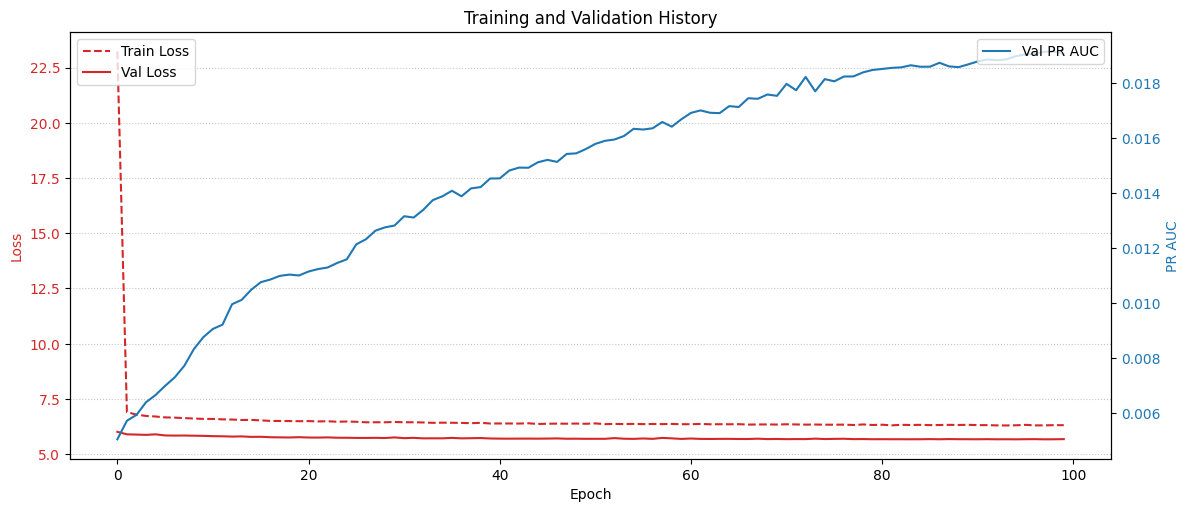

In [8]:
# Cell 8 code (Model Init & Training) is identical to the previous final global
# notebook version (v18). It uses the file paths, N_CELLS, N_FEATURES,
# and data loaders prepared specifically for the high-res Japan model in Cell 7.
# It calculates pos_weight based on the stratified training labels.

# 7. Initialize Model and Training Components
adj_matrix = create_regional_adjacency_matrix() # Use regional function

if 'global_n_features' not in locals() or global_n_features <= 0: raise NameError("global_n_features undefined.")
N_FEATURES = global_n_features
model = STGNN(N_CELLS, N_FEATURES, adj_matrix).to(DEVICE) # Use Japan N_CELLS
print(f"\nModel initialized: {N_FEATURES} features, {N_CELLS} cells.")

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Calculate pos weight using ONLY train labels
if 'train_labels_for_weight_calc' not in locals() or train_labels_for_weight_calc.empty:
     print("Warn: train_labels empty. Using weight 1.0")
     pos_weight_value = 1.0
else:
    pos_samples = (train_labels_for_weight_calc.values == 1).sum()
    neg_samples = (train_labels_for_weight_calc.values == 0).sum()
    if pos_samples > 0: pos_weight_value = np.clip(neg_samples / pos_samples, 1.0, 10000.0) # Aggressive weight
    else: print("Warn: No positive samples in training set! Weight=1.0"); pos_weight_value = 1.0
pos_weight = torch.tensor([pos_weight_value], device=DEVICE)

print(f"Pos samples (cells*weeks) in train label set: {pos_samples if 'pos_samples' in locals() else 'N/A'}")
print(f"Using positive class weight: {pos_weight.item():.2f}")

criterion = nn.BCELoss(weight=pos_weight)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
early_stopper = EarlyStopping(patience=PATIENCE, verbose=True, path=MODEL_FILE_PATH) # Use Japan path

# 8. Train the Model
if val_loader:
    history = train_model(train_loader, val_loader, model, optimizer, criterion, scheduler, early_stopper)
    # Plotting history (same code as before)
    if history and history.get('train_loss') and history.get('val_loss'):
         print("\nPlotting training history...")
         fig, ax1 = plt.subplots(figsize=(12, 5)); color = 'tab:red'; ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss', color=color)
         ax1.plot(history['train_loss'], color=color, label='Train Loss', linestyle='--')
         valid_val_loss = [l for l in history['val_loss'] if l is not None and np.isfinite(l)]
         if valid_val_loss: ax1.plot(range(len(valid_val_loss)), valid_val_loss, color=color, label='Val Loss')
         ax1.tick_params(axis='y', labelcolor=color); ax1.legend(loc='upper left'); ax1.grid(True, axis='y', linestyle=':', alpha=0.7)
         ax2 = ax1.twinx(); color = 'tab:blue'; ax2.set_ylabel('PR AUC', color=color)
         valid_pr_auc = [p for p in history['val_pr_auc'] if p is not None and np.isfinite(p)]
         if valid_pr_auc: ax2.plot(range(len(valid_pr_auc)), valid_pr_auc, color=color, label='Val PR AUC')
         ax2.tick_params(axis='y', labelcolor=color); ax2.legend(loc='upper right')
         fig.tight_layout(); plt.title('Training and Validation History'); plt.show()
else: print("Error: Val loader None."); raise SystemExit("Validation data empty.")




--- Detailed Model Accuracy on Stratified Test Set (Japan - High Res) ---

Creating Regional Adjacency Matrix (Japan - High Res)...
Regional Adjacency Matrix created.
Loaded model: best_japan_stgnn_model_m4.5_res0.5.pth


Evaluating on Test Set:   0%|          | 0/33 [00:00<?, ?it/s]


PROBABILISTIC ACCURACY METRICS
📈 ROC-AUC Score: 0.6761
🎯 PR-AUC: 0.0161
📉 Brier Score: 0.0034

CLASSIFICATION ACCURACY METRICS
Optimal Thresh (Max F1): 0.0256

📊 Class Report (Optimal Thresh):
              precision    recall  f1-score   support

No Event (0)       1.00      1.00      1.00    545109
   Event (1)       0.06      0.04      0.05      1899

    accuracy                           0.99    547008
   macro avg       0.53      0.52      0.52    547008
weighted avg       0.99      0.99      0.99    547008


🤔 Confusion Matrix (Optimal Thresh):


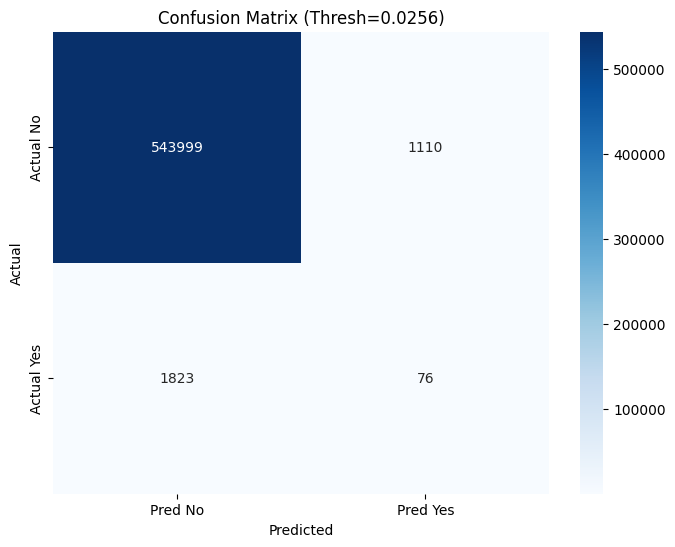

In [19]:
# Cell 9 code (Detailed Accuracy Evaluation) is identical to the previous final
# global notebook version (v18). It uses the file paths, N_CELLS, N_FEATURES,
# adj_matrix, and global_test_loader prepared specifically for the high-res Japan model.
# It calculates PR-AUC, Brier, F1-optimized classification report, and confusion matrix.

print("\n--- Detailed Model Accuracy on Stratified Test Set (Japan - High Res) ---")

if global_test_loader is None or len(global_test_loader.dataset) == 0:
    print("Test loader/dataset empty. Skipping accuracy evaluation.")
else:
    if 'global_n_features' not in locals() or global_n_features <= 0: raise NameError("global_n_features undefined.")
    N_FEATURES = global_n_features
    # Recreate adj matrix if needed
    if 'adj_matrix' not in locals() or adj_matrix.shape[0] != N_CELLS or adj_matrix.device != DEVICE:
         adj_matrix = create_regional_adjacency_matrix()

    eval_model = STGNN(N_CELLS, N_FEATURES, adj_matrix).to(DEVICE) # Use Japan N_CELLS
    model_loaded_eval = False
    if os.path.exists(MODEL_FILE_PATH): # Use Japan path
        try: eval_model.load_state_dict(torch.load(MODEL_FILE_PATH, map_location=DEVICE)); eval_model.eval(); print(f"Loaded model: {MODEL_FILE_PATH}"); model_loaded_eval = True
        except Exception as e: print(f"Error load model state: {e}")
    else: print(f"Model file '{MODEL_FILE_PATH}' not found.")

    if model_loaded_eval:
        test_loader = global_test_loader; all_labels, all_outputs = [], []
        with torch.no_grad():
            for features, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
                features, labels = features.to(DEVICE), labels.to(DEVICE)
                try:
                    outputs = eval_model(features)
                    if torch.isnan(outputs).any(): continue
                    all_labels.append(labels.cpu().numpy().flatten()); all_outputs.append(outputs.cpu().numpy().flatten())
                except Exception as e: print(f"Error eval batch: {e}"); continue

        if not all_labels: print("No samples processed in evaluation.")
        else:
            all_labels = np.concatenate(all_labels); all_outputs = np.concatenate(all_outputs)
            valid_idx = ~np.isnan(all_labels) & ~np.isnan(all_outputs); all_labels, all_outputs = all_labels[valid_idx], all_outputs[valid_idx]

            print("\n" + "="*50); print("PROBABILISTIC ACCURACY METRICS"); print("="*50)
            unique_labels = np.unique(all_labels)
            if len(unique_labels) > 1 and len(all_labels) > 1:
                try: roc_auc = roc_auc_score(all_labels, all_outputs); pr_auc = average_precision_score(all_labels, all_outputs); print(f"📈 ROC-AUC Score: {roc_auc:.4f}"); print(f"🎯 PR-AUC: {pr_auc:.4f}")
                except Exception as e: print(f"Could not calc ROC/PR-AUC: {e}")
            else: print(f"Only one class ({unique_labels}) or insufficient samples. ROC/PR-AUC undefined.")
            brier = brier_score_loss(all_labels, all_outputs) if len(all_labels) > 0 else float('nan'); print(f"📉 Brier Score: {brier:.4f}"); print("="*50 + "\n")

            print("CLASSIFICATION ACCURACY METRICS"); print("="*50)
            if len(unique_labels) > 1 and np.sum(all_labels) > 0 and len(all_labels) > 1:
                try:
                    precision, recall, thresholds = precision_recall_curve(all_labels, all_outputs)
                    min_len = min(len(precision), len(recall)); thresholds = thresholds[:min_len-1]; precision, recall = precision[:min_len], recall[:min_len]
                    f1 = np.divide(2*precision*recall, precision+recall+1e-10, out=np.zeros_like(precision), where=(precision+recall)>0)
                    if len(f1[:-1]) > 0 : optimal_idx = np.argmax(f1[:-1]); optimal_thresh = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5; print(f"Optimal Thresh (Max F1): {optimal_thresh:.4f}")
                    else: optimal_thresh = 0.5; print("Could not find optimal threshold, using 0.5")
                    preds_bin = (all_outputs >= optimal_thresh).astype(int)
                    report = classification_report(all_labels, preds_bin, target_names=['No Event (0)', 'Event (1)'], zero_division=0)
                    print("\n📊 Class Report (Optimal Thresh):"); print(report); print("="*50 + "\n")
                    print("🤔 Confusion Matrix (Optimal Thresh):")
                    cm = confusion_matrix(all_labels, preds_bin); plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No', 'Pred Yes'], yticklabels=['Actual No', 'Actual Yes'])
                    plt.title(f'Confusion Matrix (Thresh={optimal_thresh:.4f})'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()
                except Exception as e: print(f"Error during classification metrics: {e}")
            else: print("Cannot calculate class report/matrix (only one class or no positive samples).")



--- Loading best model and scaler for final Japan forecast ---
Recreating adjacency matrix for prediction...

Creating Regional Adjacency Matrix (Japan - High Res)...
Regional Adjacency Matrix created.
Using scaler fitted during training.
Loaded model: best_japan_stgnn_model_m4.5_res0.5.pth

--- Generating Forecast for Next Week (Japan Region - High Res) ---

--- Fetching Data from USGS for Region (24.0-46.0°N, 122.0-146.0°E) ---


Fetching Data Chunks:   0%|          | 0/15 [00:00<?, ?it/s]

Fetched 1274 unique events from 2024-08-18 04:58:15.859000+00:00 to 2025-10-25 11:45:23.124000+00:00.

--- Preprocessing Data (Japan Region - High Res) ---
Pivoting data...
Applying Feature Scaling...
Scaling applied.
Preprocessing complete.
Prediction OK. Shape: (2112,). Min: 5.34e-04, Max: 3.80e-02

--- Visualizing Hazard Map (Japan Region - High Res) ---
Loading world map from: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Plotting probabilities ranging from 5.343e-04 to 3.799e-02


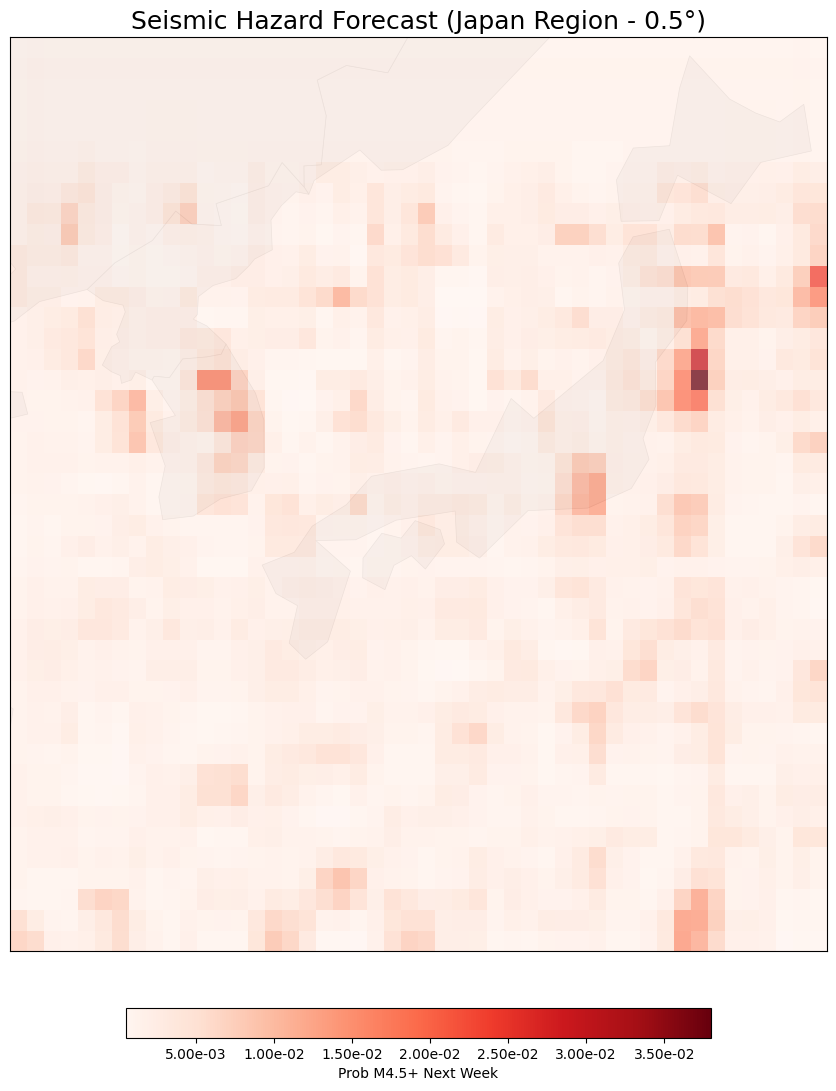


--- Japan Forecasting Complete ---


In [18]:
# CELL 10 (Corrected Version - Pass Grid Arguments to Visualization)

# 9. Load the Best Model and Scaler for Final Forecast
print("\n--- Loading best model and scaler for final Japan forecast ---")

# Ensure N_FEATURES defined globally
if 'global_n_features' not in locals() or global_n_features <= 0: raise NameError("global_n_features undefined.")
N_FEATURES = global_n_features
# Ensure adj_matrix defined globally and correct
if 'adj_matrix' not in locals() or adj_matrix is None or adj_matrix.shape[0] != N_CELLS or adj_matrix.device != DEVICE:
     print("Recreating adjacency matrix for prediction...")
     adj_matrix = create_regional_adjacency_matrix() # Use regional

final_model = STGNN(N_CELLS, N_FEATURES, adj_matrix).to(DEVICE) # Use Japan N_CELLS

# Load scaler (ensure global_scaler from Cell 7 or load from file)
final_scaler = None
if 'global_scaler' in locals() and global_scaler is not None and hasattr(global_scaler, 'mean_'):
    final_scaler = global_scaler; print("Using scaler fitted during training.")
elif os.path.exists(SCALER_FILE_PATH): # Use Japan path
    try: final_scaler = joblib.load(SCALER_FILE_PATH); print(f"Loaded scaler: {SCALER_FILE_PATH}");
    except Exception as e: print(f"Error load scaler: {e}.")
else: print(f"Error: Scaler not found (memory/file: {SCALER_FILE_PATH}).")

# Load model state dict
model_loaded = False
if os.path.exists(MODEL_FILE_PATH): # Use Japan path
    try: final_model.load_state_dict(torch.load(MODEL_FILE_PATH, map_location=DEVICE)); print(f"Loaded model: {MODEL_FILE_PATH}"); model_loaded = True
    except Exception as e: print(f"Error load model state: {e}")
else: print(f"Model file {MODEL_FILE_PATH} not found.")

# Proceed only if model loaded and scaler valid
if model_loaded and final_scaler is not None and hasattr(final_scaler, 'mean_'):
    # 10. Generate Final Forecast
    final_hazard_probabilities = predict_latest_hazard(final_model, final_scaler) # Uses Japan bounds via Cell 1 config

    # --- !! MODIFIED FUNCTION CALL !! ---
    # 11. Visualize Final Forecast (Pass grid variables explicitly)
    # Ensure grid variables exist from Cell 1
    if 'lat_bins' not in locals() or 'lon_bins' not in locals() or \
       'N_LAT_BINS' not in locals() or 'N_LON_BINS' not in locals() or \
       'N_CELLS' not in locals() or 'MIN_LAT' not in locals() or \
       'MAX_LAT' not in locals() or 'MIN_LON' not in locals() or \
       'MAX_LON' not in locals() or 'TARGET_MAGNITUDE' not in locals():
           print("Error: Grid variables from Cell 1 not found. Cannot visualize. Rerun Cell 1.")
    else:
        visualize_regional_hazard_map(
            probabilities=final_hazard_probabilities,
            lat_bins_vis=lat_bins,
            lon_bins_vis=lon_bins,
            N_LAT_BINS_vis=N_LAT_BINS,
            N_LON_BINS_vis=N_LON_BINS,
            N_CELLS_vis=N_CELLS,
            MIN_LAT_vis=MIN_LAT,
            MAX_LAT_vis=MAX_LAT,
            MIN_LON_vis=MIN_LON,
            MAX_LON_vis=MAX_LON,
            TARGET_MAGNITUDE_vis=TARGET_MAGNITUDE
        )
    # --- END MODIFIED CALL ---


    print("\n--- Japan Forecasting Complete ---")
elif model_loaded and (final_scaler is None or not hasattr(final_scaler, 'mean_')):
     print("\n--- Skipping Final Forecast: Scaler invalid or unavailable ---")
else:
     print("\n--- Skipping Final Forecast: Model unavailable ---")